In [1]:
import os
import statistics as st
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, precision_score, classification_report

from IPython.display import display

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# 1. Definition
The purpose of this analysis is to demonstrate the possibility of customer conversion. Specifically we would like to explore the possibility of recruiting an existing credit card customer as a loan customer. For the purpose of this analysis, we will use a public financial dataset containing application, bureau and behavior data.

We will attempt to find features that can predict if a customer has ever opened of a loan account. We will then build a model that predicts the target event (loan account opened).

## 1.1 Problem Statement
Credit cards are a ubiquitous product and banks usually have large credit card portfolios. If a bank wishes to expand their loan portfolio, marketing costs could prohibit large one-off campaigns for new customers. However, recruiting existing customers incurs minimal marketing costs. At the same time, existing customers have a behavior history that could be re-used for risk assessment.

We will use a sample of customers who have a credit card account and a consumer loan account. We will then model the likelihood of a credit card customer having a loan account in addition.

## 1.2 Metrics
The outcome that we will model on is binary. It answers the question: 'did the customer open an account for a secondary product?'

To achieve a balance between precision and recall, we will utilize the F1 score metric. It is defined as: $F1=2 \frac{P R}{P + R}$

# 2. Analysis
## 2.1 Data Exploration
In this analysis, we will use the [Home Credit Default dataset from Kaggle](https://www.kaggle.com/c/home-credit-default-risk/data). The dataset consists of the following files:

In [2]:
filepath = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'datasets/home_credit_default_risk'))
os.listdir(filepath)

['bureau_balance.csv.zip',
 'application_train.csv.zip',
 'credit_card_balance.csv.zip',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv.zip',
 'POS_CASH_balance.csv.zip',
 'bureau.csv.zip',
 'previous_application.csv.zip']

In [3]:
app_train = pd.read_csv(os.path.join(filepath, 'application_train.csv.zip'))

In [4]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
prev_app = pd.read_csv(os.path.join(filepath, 'previous_application.csv.zip'))

In [6]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
installment_payments = pd.read_csv(os.path.join(filepath, 'installments_payments.csv.zip'))

In [8]:
installment_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [9]:
card_balance = pd.read_csv(os.path.join(filepath, 'credit_card_balance.csv.zip'))

In [10]:
card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [11]:
def get_avg_limit_unitilisaton_last_n_months(sk_id_prev, n_months):
    cols_ = ['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE',
             'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL']
    card_balance_ = card_balance[card_balance.SK_ID_PREV == sk_id_prev]\
        .sort_values('MONTHS_BALANCE', ascending=True)[:n_months][cols_]
    return pd.Series(card_balance_.AMT_BALANCE
                     / card_balance_.AMT_CREDIT_LIMIT_ACTUAL).mean()


def get_avg_ratio_last_n_months_cc(sk_id_prev, col1, col2, n_months):
    card_balance_ = card_balance[card_balance.SK_ID_PREV == sk_id_prev]\
        .sort_values('MONTHS_BALANCE', ascending=True)[:n_months]
    return pd.Series(card_balance_[col1] / card_balance_[col2]).mean()


def get_prev_cc_acc(sk_id_curr):
    card_balance_ = card_balance[card_balance.SK_ID_CURR == sk_id_curr]
    return list(card_balance_.SK_ID_PREV.unique())


def get_prev_loan_acc(sk_id_curr):
    installment_payments_ = installment_payments[installment_payments.SK_ID_CURR == sk_id_curr]
    return list(installment_payments_.SK_ID_PREV.unique())

## 2.2 Find Applicants With One or More Credit Cards

In [12]:
prev_cc = pd.pivot_table(data=card_balance,
                         index='SK_ID_CURR',
                         values='SK_ID_PREV',
                         aggfunc=lambda x: len(x.unique()),
                         fill_value=0)

In [13]:
prev_cc = prev_cc.rename(columns={'SK_ID_PREV' : 'num_cc'})

## 2.3 Calculate The Number of Months of Credit Card History

In [14]:
all_cards_per_cust = pd.pivot_table(data=card_balance,
                                    index=['SK_ID_CURR', 'SK_ID_PREV'],
                                    values='MONTHS_BALANCE',
                                    aggfunc='min')

all_cards_per_cust = all_cards_per_cust * -1

num_months_cc_hist = pd.pivot_table(data=all_cards_per_cust,
                                      index=all_cards_per_cust.index.get_level_values('SK_ID_CURR'),
                                      values='MONTHS_BALANCE',
                                      aggfunc='max')

num_months_cc_hist = num_months_cc_hist.rename(columns={'MONTHS_BALANCE' : 'months_cc_hist'})

## 2.4 Find Applicants With One or More Loans

In [15]:
prev_loan = pd.pivot_table(data=installment_payments,
                           index='SK_ID_CURR',
                           values='SK_ID_PREV',
                           aggfunc=lambda x: len(x.unique()),
                           fill_value=0)

prev_loan = prev_loan.rename(columns={'SK_ID_PREV' : 'num_loans'})

## 2.5 Calculate The Number of Months of Loan History

In [16]:
all_loans_per_cust = pd.pivot_table(data=installment_payments,
                                    index=['SK_ID_CURR', 'SK_ID_PREV'],
                                    values='NUM_INSTALMENT_NUMBER',
                                    aggfunc='max')

num_months_loan_hist = pd.pivot_table(data=all_loans_per_cust,
                                      index=all_loans_per_cust.index.get_level_values('SK_ID_CURR'),
                                      values='NUM_INSTALMENT_NUMBER',
                                      aggfunc='max')

num_months_loan_hist = num_months_loan_hist.rename(columns={'NUM_INSTALMENT_NUMBER' : 'months_loans_hist'})

## 2.6 Merge Data

In [17]:
app_train_enriched = app_train.merge(prev_cc,
                                     how='left',
                                     left_on='SK_ID_CURR',
                                     right_index=True)\
    .merge(prev_loan,
           how='left',
           left_on='SK_ID_CURR',
           right_index=True)\
    .merge(num_months_cc_hist,
           how='left',
           left_on='SK_ID_CURR',
           right_index=True)\
    .merge(num_months_loan_hist,
           how='left',
           left_on='SK_ID_CURR',
           right_index=True)

In [18]:
for c in ['num_cc', 'num_loans', 'months_cc_hist', 'months_loans_hist']:
    app_train_enriched[c] = app_train_enriched[c].fillna(0)

## 2.7 Find Instances Of Primary Product Customers That Do / Do Not Become Secondary Product Customers
It should be noted that we want to select customer records where more than 3 payments have been observed. This would give us higher confidence in the validity of our behavior features.

In [187]:
prim_prod = 'cc'
sec_prod = 'loans'
target_col_name = f'cust_{sec_prod}'

In [188]:
cust_prim_not_cust_sec = app_train_enriched[(app_train_enriched[f'num_{prim_prod}'] > 0)
                                            & (app_train_enriched[f'num_{sec_prod}'] == 0)
                                            & (app_train_enriched[f'months_{prim_prod}_hist'] > 3)].copy()
cust_prim_not_cust_sec[target_col_name] = 0

In [189]:
cust_prim_and_cust_sec = app_train_enriched[(app_train_enriched[f'num_{prim_prod}'] > 0)
                                            & (app_train_enriched[f'num_{sec_prod}'] > 0)
                                            & (app_train_enriched[f'months_{prim_prod}_hist'] > 3)
                                           ].copy()
cust_prim_and_cust_sec[target_col_name] = 1

In [190]:
cust_prim_not_cust_sec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 1359 to 303264
Columns: 127 entries, SK_ID_CURR to cust_loans
dtypes: float64(69), int64(42), object(16)
memory usage: 198.0+ KB


In [191]:
cust_prim_and_cust_sec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84784 entries, 3 to 307504
Columns: 127 entries, SK_ID_CURR to cust_loans
dtypes: float64(69), int64(42), object(16)
memory usage: 82.8+ MB


In [192]:
if cust_prim_not_cust_sec.shape[0] > cust_prim_and_cust_sec.shape[0]:
    balance_size = cust_prim_and_cust_sec.shape[0]
    cust_prim_not_cust_sec = cust_prim_not_cust_sec.sample(balance_size)
else:
    balance_size = cust_prim_not_cust_sec.shape[0]
    cust_prim_and_cust_sec = cust_prim_and_cust_sec.sample(balance_size)

In [193]:
df = cust_prim_and_cust_sec.append(cust_prim_not_cust_sec).sample(frac=1.)

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 273483 to 85491
Columns: 127 entries, SK_ID_CURR to cust_loans
dtypes: float64(69), int64(42), object(16)
memory usage: 396.0+ KB


In [195]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,num_cc,num_loans,months_cc_hist,months_loans_hist,cust_loans
273483,417004,0,Cash loans,F,N,Y,0,135000.0,675000.0,19867.5,...,NaN,NaN,NaN,NaN,NaN,1.0,0.0,96.0,0.0,0
9869,111485,0,Cash loans,F,N,N,2,81000.0,225000.0,14778.0,...,0.0,0.0,0.0,0.0,1.0,1.0,2.0,88.0,87.0,1
86764,200704,0,Cash loans,M,N,N,0,157500.0,814041.0,23800.5,...,0.0,0.0,0.0,0.0,4.0,1.0,4.0,10.0,21.0,1
54209,162804,1,Cash loans,F,N,N,0,202500.0,450000.0,21780.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,95.0,0.0,0
84191,197669,0,Cash loans,M,Y,Y,2,135000.0,544491.0,16047.0,...,0.0,0.0,0.0,2.0,1.0,1.0,1.0,74.0,36.0,1


Unfortunately, there are less than 500 customer records that we can work with. This means that we should expect suboptimal results in terms of score for our chosen metric. In any event, this proof of concept could be supplemented by simulated data later on.

## 2.8 Feature Engineering
We will define the following behavior features:

* limit utilisation last n months: the mean of the balance divided by the limit for the last n months or less.
* payment as percentage of balance last n months: the mean of the payment amount divided by the balance amount for the last n months or less.

In addition, we will define one more application feature: credit as percentage of goods price: `AMT_CREDIT` / `AMT_GOODS_PRICE`.

In [196]:
df['credit_pct_goods_price'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

In [197]:
for n in [6, 12]:
    df[f'limit_util_last_{n}_months'] = [st.mean([get_avg_limit_unitilisaton_last_n_months(sk_id_prev, n)
                                                  for sk_id_prev in get_prev_cc_acc(sk_id_curr)])
                                         for sk_id_curr in df.SK_ID_CURR]
    df[f'limit_util_last_{n}_months'] = df[f'limit_util_last_{n}_months'].fillna(0)

In [198]:
for n in [6, 12]:
    df[f'payment_pct_bal_last_{n}_months'] = [st.mean([get_avg_ratio_last_n_months_cc(sk_id_prev,
                                                                                   'AMT_BALANCE',
                                                                                   'AMT_PAYMENT_CURRENT',
                                                                                   n)
                                                       for sk_id_prev in get_prev_cc_acc(sk_id_curr)])
                                              for sk_id_curr in df.SK_ID_CURR]
    df[f'payment_pct_bal_last_{n}_months'] = df[f'payment_pct_bal_last_{n}_months'].fillna(0)

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 273483 to 85491
Columns: 132 entries, SK_ID_CURR to payment_pct_bal_last_12_months
dtypes: float64(74), int64(42), object(16)
memory usage: 411.5+ KB


## 2.9 Exploratory Visualisation
Let us plot the count of each category for a selection of categorical features. We will split the count by target outcome:

In [200]:
def count_by_feature(feature, df):
    to_plot = pd.pivot_table(data=df,
                             index=[feature, 'cust_loans'],
                             values='SK_ID_CURR',
                             aggfunc='count').reset_index()
    return sns.barplot(x=feature, y='SK_ID_CURR', hue='cust_loans', data=to_plot)

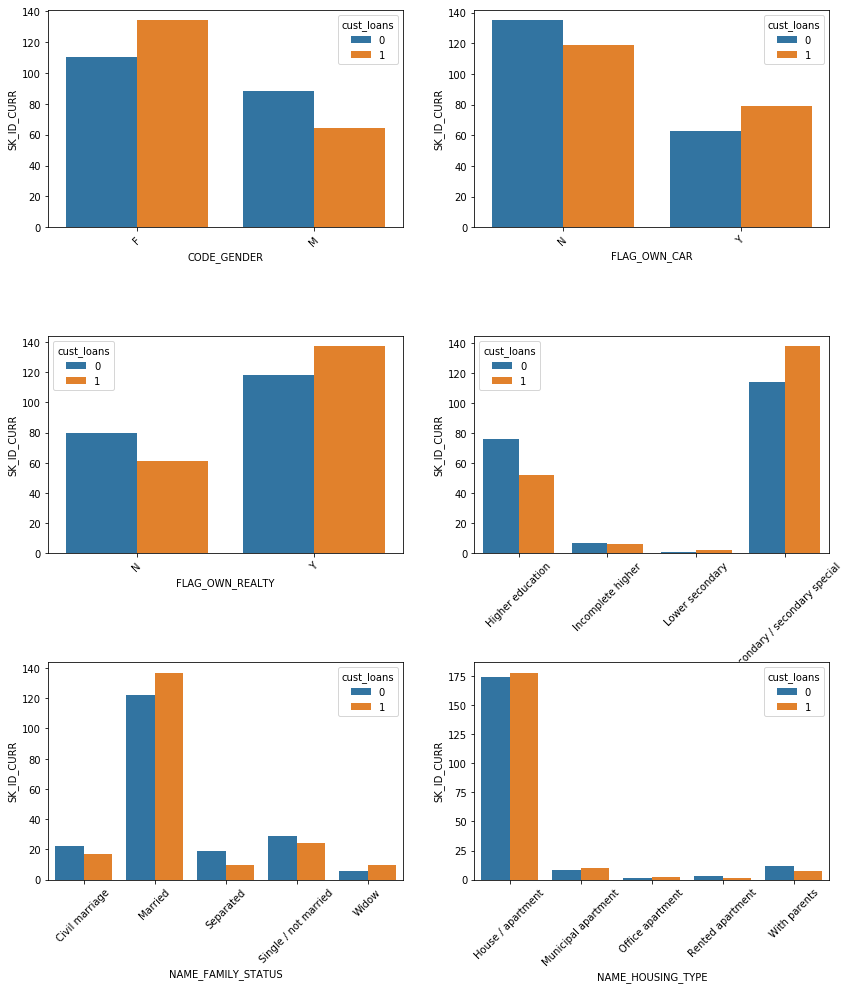

In [201]:
fig = plt.figure(figsize=(14, 16))
features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
            'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
            'NAME_HOUSING_TYPE']

n_cols = 2
n_rows = int(len(features)/2) + len(features)%2

for i, f in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, i+1)
    g = count_by_feature(f, df)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplots_adjust(hspace=0.5)

We would also like to plot the distribution of a selection of numerical features by target outcome:

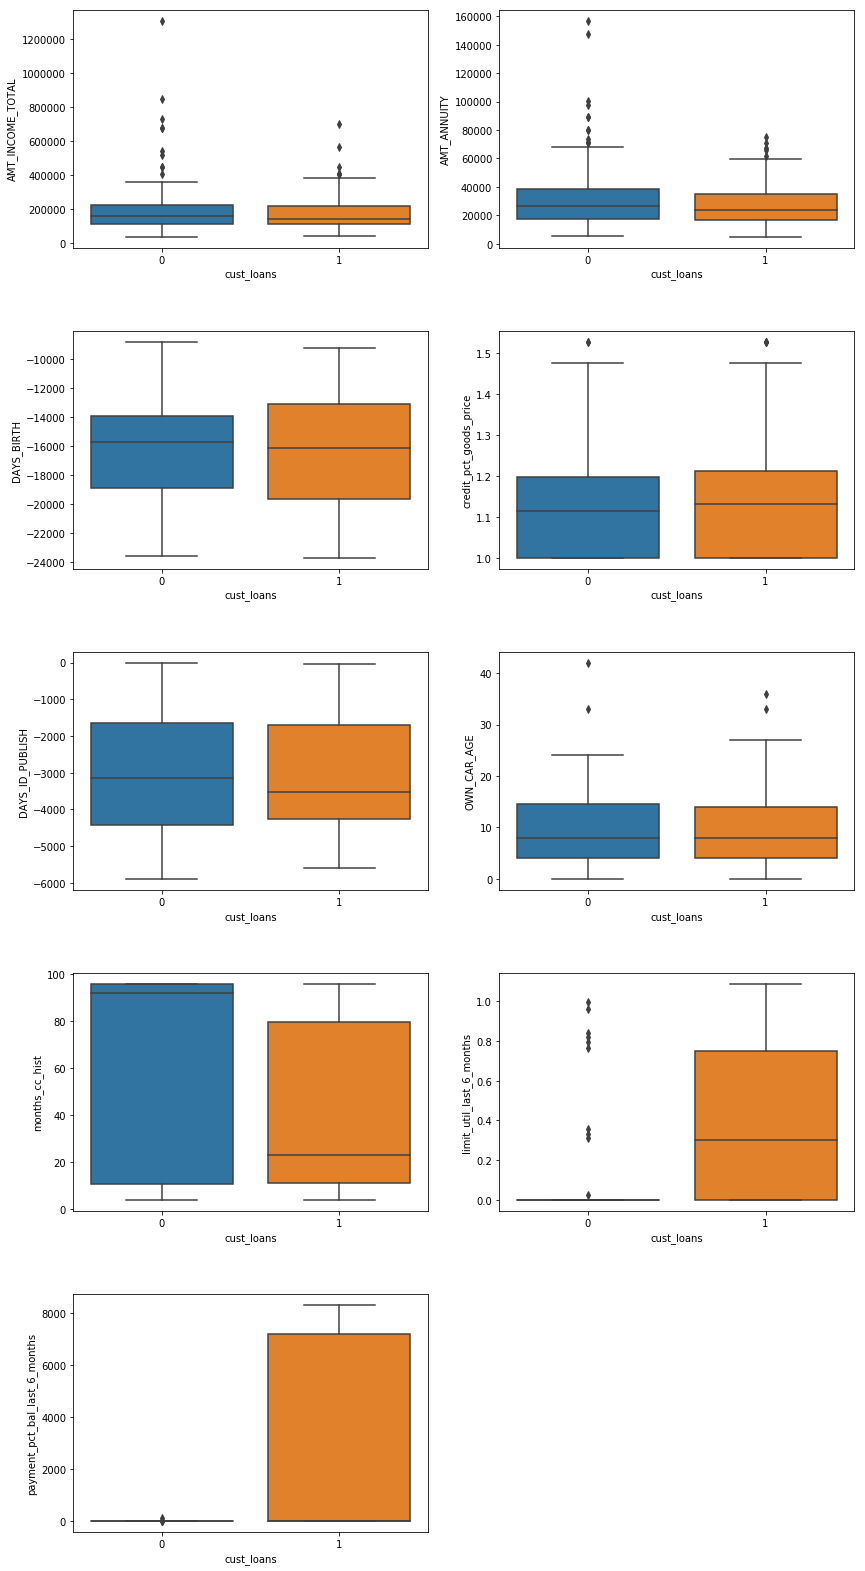

In [322]:
fig = plt.figure(figsize=(14, 28))
features = ['AMT_INCOME_TOTAL',
            'AMT_ANNUITY',
            'DAYS_BIRTH',
            'credit_pct_goods_price',
            'DAYS_ID_PUBLISH',
            'OWN_CAR_AGE',
            f'months_{prim_prod}_hist',
            'limit_util_last_6_months',
            'payment_pct_bal_last_6_months'
            # 'min_payment_pct',
           ]

n_cols = 2
n_rows = int(len(features)/2) + len(features)%2

for i, f in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, i+1)
    g = sns.boxplot(x=target_col_name, y=f, data=df)

plt.subplots_adjust(hspace=0.35)

# 3. Methodology
## 3.1 Algorithms and Techniques
We will build a decision tree model using a combination of application and behavior features. Our choice of model is based on the following requirements:
* Explainability. We can extract the rules from a decision tree. This is especially valid in the case of a pruned tree. A low value for the `max_depth` hyperparameter guarantees that the results of the model could be explained to end users.
* Independence of scale. Since decision trees' accuracy is not dependent on the difference between the scale of the features, fast prototyping is guaranteed.
* Possibility of extraction of the most important features.

## 3.2 Data Pre-Processing
Our data processing pipeline consists of:

1. One-hot encoding of the categorical features
2. Merging the one-hot encoded categorical features with the numeric features.

In [409]:
cat_features = [
                'CODE_GENDER',
                'FLAG_OWN_REALTY',
                'NAME_EDUCATION_TYPE',
                # 'FLAG_OWN_CAR',
                # 'NAME_FAMILY_STATUS'
               ]
num_features = [
                # 'AMT_INCOME_TOTAL',
                # 'AMT_ANNUITY',
                # 'DAYS_BIRTH',
                # 'credit_pct_goods_price',
                'DAYS_ID_PUBLISH',
                # 'OWN_CAR_AGE',
                f'months_{prim_prod}_hist',
                'limit_util_last_6_months',
                # 'payment_pct_bal_last_6_months'
               ]

for f in num_features:
    df[f] = df[f].fillna(0).replace(np.inf, 0).replace(-np.inf, 0)

X = pd.get_dummies(data=df[cat_features], columns=cat_features)
X = X.join(df[num_features])
y = df[target_col_name]

In [410]:
X.drop([
        'NAME_EDUCATION_TYPE_Incomplete higher',
        'NAME_EDUCATION_TYPE_Lower secondary',
        'CODE_GENDER_M',
        # 'FLAG_OWN_CAR_N',
        'FLAG_OWN_REALTY_N',
        # 'NAME_FAMILY_STATUS_Civil marriage',
        # 'NAME_FAMILY_STATUS_Married',
        # 'NAME_FAMILY_STATUS_Separated',
        # 'NAME_FAMILY_STATUS_Widow'
       ],
       axis=1, inplace=True)

In [411]:
X.head()

,CODE_GENDER_F,FLAG_OWN_REALTY_Y,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,DAYS_ID_PUBLISH,months_cc_hist,limit_util_last_6_months
273483,1,1,0,1,-3373,96.0,0.000000
9869,1,0,1,0,-3657,88.0,0.000000
86764,0,0,0,1,-4462,10.0,0.519934
54209,1,0,0,1,-4507,95.0,0.000000
84191,0,1,0,1,-4513,74.0,0.000000


## 3.3 Implementation
We will perform a grid search optimization of the decision tree. The grid search will have the following parameters:

* Optimization criterion: `gini` or `entropy`
* Max depth: [2, 10]
* Max features: [2, max]

We will also use 3-fold cross validation in order to recycle our data for training and testing.

In [412]:
random_seed = 42
cv = 3
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': np.arange(2, 10+1),
              'max_features': np.arange(2, len(X.columns) + 1)}
training_sizes = np.arange(0.1, 1.1, 0.1)
test_size = 0.25

In [413]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

In [414]:
estimator = DecisionTreeClassifier(random_state=random_seed)
scorer = make_scorer(f1_score)

grid_search = GridSearchCV(estimator=estimator,
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=cv)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'max_features': array([2, 3, 4, 5, 6, 7])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=0)

In [415]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 3, 'max_features': 2}

In [416]:
grid_search.best_score_

0.8257148257148257

In [417]:
grid_search.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

# 4. Results
We will start the results evaluation by plotting the learning curves for the best estimator (from our grid search exercise).

In [418]:
def show_learning_curves(estimator, X, y, cv, train_sizes, scorer):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator,
                                                            X=X,
                                                            y=y,
                                                            cv=cv,
                                                            train_sizes=train_sizes,
                                                            scoring=scorer)
    
    cols_ = list(range(train_scores.shape[1]))
    cols_.extend(['size', 'type'])
    learning_curve_res = pd.DataFrame(columns=cols_)
    
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        learning_curve_res = learning_curve_res.append(frame, ignore_index=True)
    
    # with pd suppress warnings
    learning_curve_res = learning_curve_res.melt(id_vars=['size', 'type'],
                                                 var_name='cv_fit',
                                                 value_name='score')
    
    g = plt.figure(figsize=(12, 10))
    g = sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
    g.set_ylim(0, 1.)
    g.set_title('Learning Curves')
    plt.show(g)

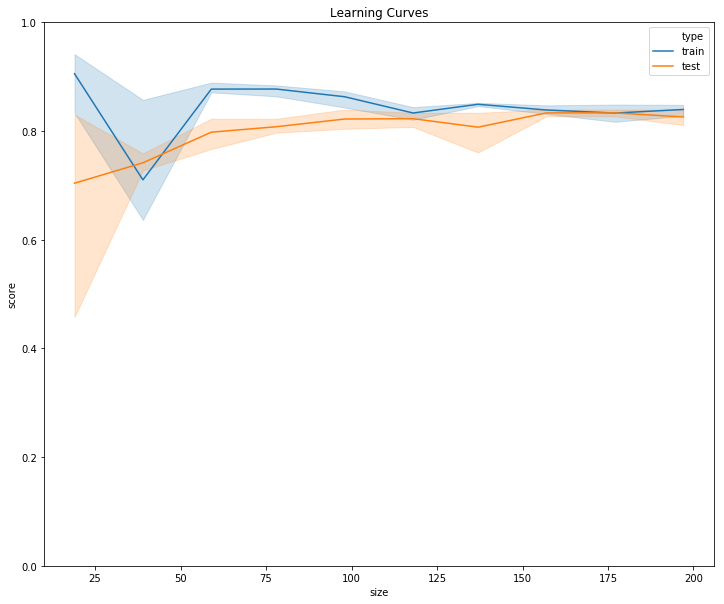

In [419]:
show_learning_curves(grid_search.best_estimator_, X_train, y_train, cv, training_sizes, scorer)

Next, we would like to investigate the feature importance of our best estimator.

In [420]:
pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)

limit_util_last_6_months                             0.640476
months_cc_hist                                       0.233479
DAYS_ID_PUBLISH                                      0.076827
CODE_GENDER_F                                        0.031223
NAME_EDUCATION_TYPE_Higher education                 0.017996
NAME_EDUCATION_TYPE_Secondary / secondary special    0.000000
FLAG_OWN_REALTY_Y                                    0.000000
dtype: float64

Finally, we print a classification report and a cross validation score sample.

In [421]:
print(classification_report(y_true=y_test,
                            y_pred=grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        53
           1       0.73      0.89      0.80        46

   micro avg       0.80      0.80      0.80        99
   macro avg       0.81      0.80      0.80        99
weighted avg       0.81      0.80      0.80        99



In [422]:
cross_val_score(estimator=grid_search.best_estimator_,
                X=X_test, y=y_test, scoring=scorer, cv=cv)

array([0.74285714, 0.76470588, 0.69565217])